# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

Мы научимся обрабатывать пропуски в данных для количественных (числовых) и категориальных признаков и масштабировать данные. Также мы научимся преобразовывать категориальные признаки в числовые.

### В чем состоит проблема?

- Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
- Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
- Большинство алгоритмов показывает лучшее качество на масштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

## Загрузка и первичный анализ данных

https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data

In [ ]:
# Будем использовать только обучающую выборку
data = pd.read_csv('car_prices.csv', sep=",")

In [ ]:
# размер набора данных
data.shape

(458983, 16)

In [ ]:
# типы колонок
data.dtypes

year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
mmr             float64
sellingprice    float64
saledate         object
dtype: object

In [ ]:
# проверим есть ли пропущенные значения
data.isnull().sum()

year                0
make             8202
model            8274
trim             8531
body            11075
transmission    52143
vin                 0
state               0
condition       11802
odometer           90
color             643
interior          643
seller              0
mmr                18
sellingprice        9
saledate           10
dtype: int64

In [ ]:
# Первые 5 строк датасета
data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [ ]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 458983


# Обработка пропусков в данных

## Простые стратегии - удаление или заполнение нулями

Удаление колонок, содержащих пустые значения
`res = data.dropna(axis=1, how='any')`

Удаление строк, содержащих пустые значения
`res = data.dropna(axis=0, how='any')`

[Документация](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

**Удаление может производиться для группы строк или колонок.**

In [ ]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((458983, 16), (458983, 4))

In [ ]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((458983, 16), (387537, 16))

In [ ]:
data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [ ]:
# Заполнение всех пропущенных значений нулями
# В данном случае это некорректно, так как нулями заполняются в том числе категориальные колонки
data_new_3 = data.fillna(0)
data_new_3.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


## "Внедрение значений" - импьютация (imputation)

### Обработка пропусков в числовых данных

In [ ]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data.columns:
    # Количество пустых значений
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка condition. Тип данных float64. Количество пустых значений 10929, 27.27%.
Колонка odometer. Тип данных float64. Количество пустых значений 68, 0.17%.
Колонка mmr. Тип данных float64. Количество пустых значений 1, 0.0%.
Колонка sellingprice. Тип данных float64. Количество пустых значений 1, 0.0%.


In [ ]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,condition,odometer,mmr,sellingprice
0,5.0,16639.0,20500.0,21500.0
1,5.0,9393.0,20800.0,21500.0
2,45.0,1331.0,31900.0,30000.0
3,41.0,14282.0,27500.0,27750.0
4,43.0,2641.0,66000.0,67000.0
...,...,...,...,...
458978,39.0,28670.0,19450.0,20300.0
458979,37.0,75525.0,10700.0,11000.0
458980,35.0,90725.0,14700.0,12687.0
458981,31.0,32808.0,23700.0,23800.0


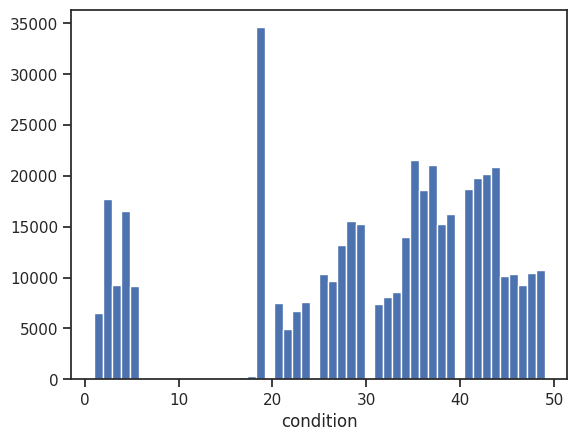

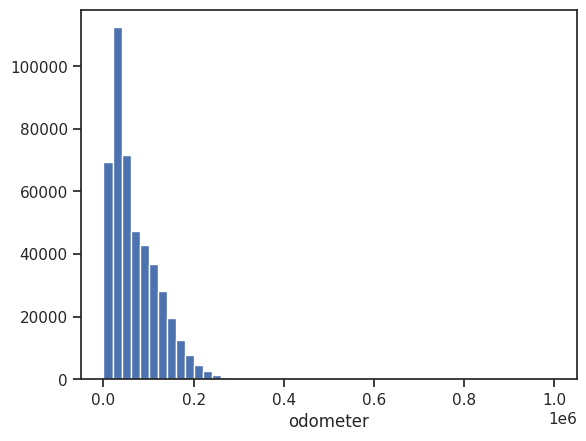

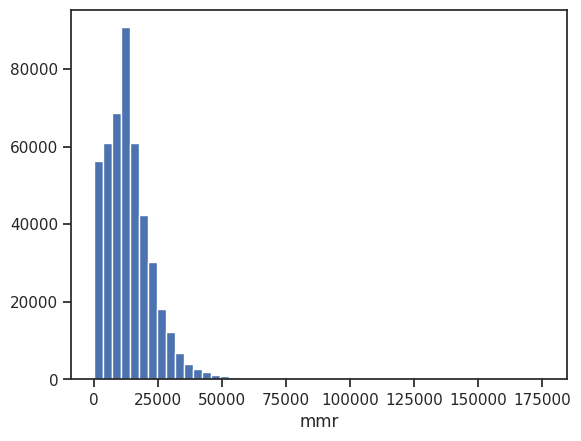

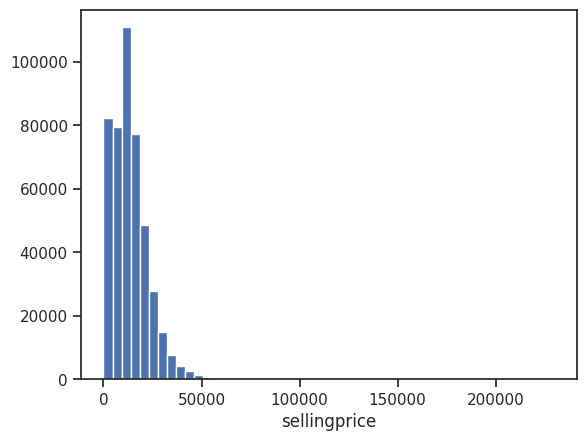

In [ ]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

Будем использовать встроенные средства импьютации библиотеки scikit-learn - https://scikit-learn.org/stable/modules/impute.html

In [ ]:
data_num_MasVnrArea = data_num[['MasVnrArea']]
data_num_MasVnrArea.head()

,MasVnrArea
0,196.0
1,0.0
2,162.0
3,0.0
4,350.0


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [ ]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_MasVnrArea)
mask_missing_values_only

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

С помощью класса [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) можно проводить импьютацию различными [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)

In [ ]:
strategies=['mean', 'median', 'most_frequent']

In [ ]:
#condition	odometer	mmr	sellingprice

In [ ]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]

    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)

    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)

    filled_data = data_num_imp[mask_missing_values_only]

    return column, strategy_param, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [ ]:
data[['mmr']].describe()

,mmr
count,458965.000000
mean,13599.871014
std,9488.783680
min,25.000000
25%,6925.000000
50%,12200.000000
75%,18150.000000
max,176000.000000


In [ ]:
data[['sellingprice']].describe()

,sellingprice
count,458974.000000
mean,13428.317367
std,9562.206694
min,1.000000
25%,6700.000000
50%,12000.000000
75%,18000.000000
max,230000.000000


In [ ]:
data[['odometer']].describe()

,odometer
count,458893.000000
mean,68885.740214
std,53876.979148
min,1.000000
25%,28422.000000
50%,52646.000000
75%,100230.000000
max,999999.000000


In [ ]:
data[['condition']].describe()

,condition
count,447181.000000
mean,30.528549
std,13.532865
min,1.000000
25%,23.000000
50%,34.000000
75%,41.000000
max,49.000000


In [ ]:
clean_n_data =  data.copy()

In [ ]:
for col in num_cols:
    clean_n_data[col].fillna(clean_n_data[col].median(), inplace = True)
    print(clean_n_data[col].isna().sum())

0
0
0
0


In [ ]:
test_num_impute_col(data, 'condition', strategies[0])

('condition', 'mean', 11802, 30.528548842638664, 30.528548842638664)

In [ ]:
test_num_impute_col(data, 'condition', strategies[1])

('condition', 'median', 11802, 34.0, 34.0)

In [ ]:
test_num_impute_col(data, 'condition', strategies[2])

('condition', 'most_frequent', 11802, 19.0, 19.0)

In [ ]:
test_num_impute_col(data, 'odometer', strategies[0])

('odometer', 'mean', 90, 68885.74021394966, 68885.74021394966)

In [ ]:
test_num_impute_col(data, 'odometer', strategies[1])

('odometer', 'median', 90, 52646.0, 52646.0)

In [ ]:
test_num_impute_col(data, 'odometer', strategies[2])

('odometer', 'most_frequent', 90, 1.0, 1.0)

In [ ]:
clean_n_data.isnull().sum()

year                0
make             8202
model            8274
trim             8531
body            11075
transmission    52143
vin                 0
state               0
condition           0
odometer            0
color             643
interior          643
seller              0
mmr                 0
sellingprice        0
saledate           10
dtype: int64

### Обработка пропусков в категориальных данных

In [ ]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка make. Тип данных object. Количество пустых значений 8202, 1.79%.
Колонка model. Тип данных object. Количество пустых значений 8274, 1.8%.
Колонка trim. Тип данных object. Количество пустых значений 8531, 1.86%.
Колонка body. Тип данных object. Количество пустых значений 11075, 2.41%.
Колонка transmission. Тип данных object. Количество пустых значений 52143, 11.36%.
Колонка color. Тип данных object. Количество пустых значений 643, 0.14%.
Колонка interior. Тип данных object. Количество пустых значений 643, 0.14%.
Колонка saledate. Тип данных object. Количество пустых значений 10, 0.0%.


In [ ]:
cat_cols

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'color',
 'interior',
 'saledate']

In [ ]:
data_cat = data[cat_cols]
data_cat

,make,model,trim,body,transmission,color,interior,saledate
0,Kia,Sorento,LX,SUV,automatic,white,black,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,Kia,Sorento,LX,SUV,automatic,white,beige,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,BMW,3 Series,328i SULEV,Sedan,automatic,gray,black,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,Volvo,S60,T5,Sedan,automatic,white,black,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,BMW,6 Series Gran Coupe,650i,Sedan,automatic,gray,black,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...
458978,Subaru,Outback,2.5i Premium,Wagon,automatic,green,tan,Wed May 27 2015 03:30:00 GMT-0700 (PDT)
458979,Toyota,Camry,LE,Sedan,automatic,silver,gray,Tue May 26 2015 06:00:00 GMT-0700 (PDT)
458980,Toyota,Camry Hybrid,XLE,Sedan,automatic,red,gray,Wed May 27 2015 02:30:00 GMT-0700 (PDT)
458981,Toyota,Highlander,Base,SUV,automatic,gray,black,Wed May 27 2015 02:00:00 GMT-0700 (PDT)


**Какие из этих колонок Вы бы выбрали или не выбрали для построения модели?**

Класс SimpleImputer можно использовать для категориальных признаков со стратегиями "most_frequent" или "constant".

In [ ]:
cat_temp_data = data[['make']]
cat_temp_data.head()

,make
0,Kia
1,Kia
2,BMW
3,Volvo
4,BMW


In [ ]:
cat_temp_data['make'].unique()

array(['Kia', 'BMW', 'Volvo', 'Nissan', 'Chevrolet', 'Audi', 'Ford',
       'Hyundai', 'Buick', 'Cadillac', 'Acura', 'Lexus', 'Infiniti',
       'Jeep', 'Mercedes-Benz', 'Mitsubishi', 'Mazda', 'MINI',
       'Land Rover', 'Lincoln', 'lincoln', 'Jaguar', 'Volkswagen',
       'Toyota', 'Subaru', 'Scion', 'Porsche', nan, 'bmw', 'Dodge',
       'FIAT', 'Chrysler', 'ford', 'Ferrari', 'Honda', 'GMC',
       'mitsubishi', 'Ram', 'smart', 'chevrolet', 'Bentley', 'chrysler',
       'pontiac', 'Pontiac', 'Saturn', 'Maserati', 'Mercury', 'HUMMER',
       'landrover', 'cadillac', 'land rover', 'mercedes', 'mazda',
       'toyota', 'lexus', 'gmc truck', 'honda', 'nissan', 'porsche',
       'Saab', 'Suzuki', 'dodge', 'subaru', 'Oldsmobile', 'oldsmobile',
       'hyundai', 'jeep', 'Isuzu', 'dodge tk', 'Geo', 'acura',
       'volkswagen', 'suzuki', 'kia', 'audi', 'Rolls-Royce', 'gmc',
       'maserati', 'mazda tk', 'mercury', 'buick', 'hyundai tk',
       'mercedes-b', 'vw', 'Daewoo', 'chev truck', 'f

In [ ]:
cat_temp_data[cat_temp_data['make'].isnull()].shape

(8202, 1)

In [ ]:
cat_temp_data[['make']].describe()

,make
count,450781
unique,96
top,Ford
freq,78104


In [ ]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['Kia'],
       ['Kia'],
       ['BMW'],
       ...,
       ['Toyota'],
       ['Toyota'],
       ['Toyota']], dtype=object)

In [ ]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick',
       'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'FIAT',
       'Ferrari', 'Fisker', 'Ford', 'GMC', 'Geo', 'HUMMER', 'Honda',
       'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia',
       'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'Lotus', 'MINI',
       'Maserati', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mitsubishi',
       'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Ram',
       'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki',
       'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'acura', 'airstream',
       'audi', 'bmw', 'buick', 'cadillac', 'chev truck', 'chevrolet',
       'chrysler', 'dodge', 'dodge tk', 'dot', 'ford', 'ford tk',
       'ford truck', 'gmc', 'gmc truck', 'honda', 'hyundai', 'hyundai tk',
       'jeep', 'kia', 'land rover', 'landrover', 'lexus', 'lincoln',
       'maserati', 'mazda', 'mazda tk', 'mercedes', 'mercedes-b',
       'mercury', 'mitsubish

In [ ]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['Kia'],
       ['Kia'],
       ['BMW'],
       ...,
       ['Toyota'],
       ['Toyota'],
       ['Toyota']], dtype=object)

In [ ]:
np.unique(data_imp3)

array(['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick',
       'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'FIAT',
       'Ferrari', 'Fisker', 'Ford', 'GMC', 'Geo', 'HUMMER', 'Honda',
       'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia',
       'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'Lotus', 'MINI',
       'Maserati', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mitsubishi',
       'NA', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche',
       'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru',
       'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'acura',
       'airstream', 'audi', 'bmw', 'buick', 'cadillac', 'chev truck',
       'chevrolet', 'chrysler', 'dodge', 'dodge tk', 'dot', 'ford',
       'ford tk', 'ford truck', 'gmc', 'gmc truck', 'honda', 'hyundai',
       'hyundai tk', 'jeep', 'kia', 'land rover', 'landrover', 'lexus',
       'lincoln', 'maserati', 'mazda', 'mazda tk', 'mercedes',
       'mercedes-b', 'mercury', 'mit

In [ ]:
data_imp3[data_imp3=='NA'].size

8202

In [ ]:
from sklearn.impute import SimpleImputer

# Создание экземпляра SimpleImputer с параметром strategy='most_frequent'
imputer = SimpleImputer(strategy='most_frequent')

# Преобразование данных с заменой пропущенных значений для каждого столбца
imputed_data = imputer.fit_transform(data_cat)

# Преобразованные данные в DataFrame
df_imputed = pd.DataFrame(imputed_data, columns=data_cat.columns)

df_imputed

,make,model,trim,body,transmission,color,interior,saledate
0,Kia,Sorento,LX,SUV,automatic,white,black,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,Kia,Sorento,LX,SUV,automatic,white,beige,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,BMW,3 Series,328i SULEV,Sedan,automatic,gray,black,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,Volvo,S60,T5,Sedan,automatic,white,black,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,BMW,6 Series Gran Coupe,650i,Sedan,automatic,gray,black,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...
458978,Subaru,Outback,2.5i Premium,Wagon,automatic,green,tan,Wed May 27 2015 03:30:00 GMT-0700 (PDT)
458979,Toyota,Camry,LE,Sedan,automatic,silver,gray,Tue May 26 2015 06:00:00 GMT-0700 (PDT)
458980,Toyota,Camry Hybrid,XLE,Sedan,automatic,red,gray,Wed May 27 2015 02:30:00 GMT-0700 (PDT)
458981,Toyota,Highlander,Base,SUV,automatic,gray,black,Wed May 27 2015 02:00:00 GMT-0700 (PDT)


In [ ]:
clean_n_data.shape

(458983, 16)

In [ ]:
df_imputed.shape

(458983, 8)

In [ ]:
df_imputed.isnull().sum()

make            0
model           0
trim            0
body            0
transmission    0
color           0
interior        0
saledate        0
dtype: int64

In [ ]:
clean_n_data.isnull().sum()

year                0
make             8202
model            8274
trim             8531
body            11075
transmission    52143
vin                 0
state               0
condition           0
odometer            0
color             643
interior          643
seller              0
mmr                 0
sellingprice        0
saledate           10
dtype: int64

In [ ]:
# Замена столбцов 'b' и 'c' в pd1 на столбцы 'b' и 'c' из pd2
clean_n_data.update(df_imputed)

clean_n_data

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458978,2012,Subaru,Outback,2.5i Premium,Wagon,automatic,4s4brcgc4c3208123,mn,39.0,28670.0,green,tan,jpmorgan chase bank n.a.,19450.0,20300.0,Wed May 27 2015 03:30:00 GMT-0700 (PDT)
458979,2012,Toyota,Camry,LE,Sedan,automatic,4t1bf1fk9cu575017,ga,37.0,75525.0,silver,gray,nextgear capital,10700.0,11000.0,Tue May 26 2015 06:00:00 GMT-0700 (PDT)
458980,2012,Toyota,Camry Hybrid,XLE,Sedan,automatic,4t1bd1fk1cu016762,nj,35.0,90725.0,red,gray,marano & sons auto sales inc,14700.0,12687.0,Wed May 27 2015 02:30:00 GMT-0700 (PDT)
458981,2012,Toyota,Highlander,Base,SUV,automatic,5tdbk3eh3cs134716,nj,31.0,32808.0,gray,black,leaserite leasing and sales,23700.0,23800.0,Wed May 27 2015 02:00:00 GMT-0700 (PDT)


In [ ]:
clean_n_data.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

# Преобразование категориальных признаков в числовые

In [ ]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,Kia
1,Kia
2,BMW
3,Volvo
4,BMW
...,...
458978,Subaru
458979,Toyota
458980,Toyota
458981,Toyota


## Кодирование категорий целочисленными значениями (label encoding)

В этом случае уникальные значения категориального признака кодируются целыми числами.

В scikit-learn для такого кодирования используется два класса :

- [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) - который ориентирован на применение к одному признаку. Этот класс прежде всего предназначен для кодирования целевого признака, но может быть также использован для последовательного кодирования отдельных нецелевых признаков.
- [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) - который ориентирован на применение к матрице объект-признак, то есть для кодирования матрицы нецелевых признаков.

### Использование LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
cat_enc['c1'].unique()

array(['Kia', 'BMW', 'Volvo', 'Nissan', 'Chevrolet', 'Audi', 'Ford',
       'Hyundai', 'Buick', 'Cadillac', 'Acura', 'Lexus', 'Infiniti',
       'Jeep', 'Mercedes-Benz', 'Mitsubishi', 'Mazda', 'MINI',
       'Land Rover', 'Lincoln', 'lincoln', 'Jaguar', 'Volkswagen',
       'Toyota', 'Subaru', 'Scion', 'Porsche', 'bmw', 'Dodge', 'FIAT',
       'Chrysler', 'ford', 'Ferrari', 'Honda', 'GMC', 'mitsubishi', 'Ram',
       'smart', 'chevrolet', 'Bentley', 'chrysler', 'pontiac', 'Pontiac',
       'Saturn', 'Maserati', 'Mercury', 'HUMMER', 'landrover', 'cadillac',
       'land rover', 'mercedes', 'mazda', 'toyota', 'lexus', 'gmc truck',
       'honda', 'nissan', 'porsche', 'Saab', 'Suzuki', 'dodge', 'subaru',
       'Oldsmobile', 'oldsmobile', 'hyundai', 'jeep', 'Isuzu', 'dodge tk',
       'Geo', 'acura', 'volkswagen', 'suzuki', 'kia', 'audi',
       'Rolls-Royce', 'gmc', 'maserati', 'mazda tk', 'mercury', 'buick',
       'hyundai tk', 'mercedes-b', 'vw', 'Daewoo', 'chev truck',
       'ford t

In [ ]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [ ]:
# Наименования категорий в соответствии с порядковыми номерами

# Свойство называется classes, потому что предполагается что мы решаем
# задачу классификации и каждое значение категории соответствует
# какому-либо классу целевого признака

le.classes_

array(['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick',
       'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'FIAT',
       'Ferrari', 'Fisker', 'Ford', 'GMC', 'Geo', 'HUMMER', 'Honda',
       'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia',
       'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'Lotus', 'MINI',
       'Maserati', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mitsubishi',
       'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Ram',
       'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki',
       'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'acura', 'airstream',
       'audi', 'bmw', 'buick', 'cadillac', 'chev truck', 'chevrolet',
       'chrysler', 'dodge', 'dodge tk', 'dot', 'ford', 'ford tk',
       'ford truck', 'gmc', 'gmc truck', 'honda', 'hyundai', 'hyundai tk',
       'jeep', 'kia', 'land rover', 'landrover', 'lexus', 'lincoln',
       'maserati', 'mazda', 'mazda tk', 'mercedes', 'mercedes-b',
       'mercury', 'mitsubish

In [ ]:
cat_enc_le

array([24, 24,  3, ..., 49, 49, 49])

In [ ]:
np.unique(cat_enc_le)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [ ]:
# В этом примере видно, что перед кодированием
# уникальные значения признака сортируются в лексикографиеском порядке
le.inverse_transform([0, 1, 2, 3])

array(['Acura', 'Aston Martin', 'Audi', 'BMW'], dtype=object)

### Использование OrdinalEncoder

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
data_oe = data[['make', 'model', 'transmission']]
data_oe.head()

,make,model,transmission
0,Kia,Sorento,automatic
1,Kia,Sorento,automatic
2,BMW,3 Series,automatic
3,Volvo,S60,automatic
4,BMW,6 Series Gran Coupe,automatic


In [ ]:
imp4 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_oe_filled = imp4.fit_transform(data_oe)
data_oe_filled

array([['Kia', 'Sorento', 'automatic'],
       ['Kia', 'Sorento', 'automatic'],
       ['BMW', '3 Series', 'automatic'],
       ...,
       ['Toyota', 'Camry Hybrid', 'automatic'],
       ['Toyota', 'Highlander', 'automatic'],
       ['Toyota', 'Camry', 'automatic']], dtype=object)

In [ ]:
oe = OrdinalEncoder()
cat_enc_oe = oe.fit_transform(data_oe_filled)
cat_enc_oe

array([[ 24., 650.,   2.],
       [ 24., 650.,   2.],
       [  3.,   9.,   2.],
       ...,
       [ 50., 149.,   2.],
       [ 50., 354.,   2.],
       [ 50., 148.,   2.]])

In [ ]:
# Уникальные значения 1 признака
np.unique(cat_enc_oe[:, 0])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96.])

In [ ]:
# Уникальные значения 2 признака
np.unique(cat_enc_oe[:, 1])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [ ]:
# Уникальные значения 3 признака
np.unique(cat_enc_oe[:, 2])

array([0., 1., 2., 3.])

In [ ]:
# Наименования категорий в соответствии с порядковыми номерами
oe.categories_

[array(['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick',
        'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'FIAT',
        'Ferrari', 'Fisker', 'Ford', 'GMC', 'Geo', 'HUMMER', 'Honda',
        'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia',
        'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'Lotus', 'MINI',
        'Maserati', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mitsubishi',
        'NA', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche',
        'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru',
        'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'acura',
        'airstream', 'audi', 'bmw', 'buick', 'cadillac', 'chev truck',
        'chevrolet', 'chrysler', 'dodge', 'dodge tk', 'dot', 'ford',
        'ford tk', 'ford truck', 'gmc', 'gmc truck', 'honda', 'hyundai',
        'hyundai tk', 'jeep', 'kia', 'land rover', 'landrover', 'lexus',
        'lincoln', 'maserati', 'mazda', 'mazda tk', 'mercedes',
        'mercedes-b', 

In [ ]:
# Обратное преобразование
oe.inverse_transform(cat_enc_oe)

array([['Kia', 'Sorento', 'automatic'],
       ['Kia', 'Sorento', 'automatic'],
       ['BMW', '3 Series', 'automatic'],
       ...,
       ['Toyota', 'Camry Hybrid', 'automatic'],
       ['Toyota', 'Highlander', 'automatic'],
       ['Toyota', 'Camry', 'automatic']], dtype=object)

### Проблемы использования LabelEncoder и OrdinalEncoder

Необходимо отметить, что LabelEncoder и OrdinalEncoder могут использоваться только для категориальных признаков в номинальных шкалах (для которых отсутствует порядок), например города, страны, названия рек и т.д.

Это связано с тем, что задать какой-либо порядок при кодировании с помощью LabelEncoder и OrdinalEncoder невозможно, они сортируют категории в лексикографическом порядке.

При этом кодирование целыми числами создает фиктивное отношение порядка (1 < 2 < 3 < ...) которого не было в исходных номинальных шкалах. Данное отношение порядка может негативно повлиять на построение модели машинного обучения.

### Кодирование шкал порядка

Библиотека scikit-learn не предоставляет готового решения для кодирования шкал порядка, но можно воспользоваться [функцией map для отдельных объектов Series.](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)

In [ ]:
# пример шкалы порядка 'small' < 'medium' < 'large'
sizes = ['small', 'medium', 'large', 'small', 'medium', 'large', 'small', 'medium', 'large']

In [ ]:
pd_sizes = pd.DataFrame(data={'sizes':sizes})
pd_sizes

,sizes
0,small
1,medium
2,large
3,small
4,medium
5,large
6,small
7,medium
8,large


In [ ]:
pd_sizes['sizes_codes'] = pd_sizes['sizes'].map({'small':1, 'medium':2, 'large':3})
pd_sizes

,sizes,sizes_codes
0,small,1
1,medium,2
2,large,3
3,small,1
4,medium,2
5,large,3
6,small,1
7,medium,2
8,large,3


In [ ]:
pd_sizes['sizes_decoded'] = pd_sizes['sizes_codes'].map({1:'small', 2:'medium', 3:'large'})
pd_sizes

,sizes,sizes_codes,sizes_decoded
0,small,1,small
1,medium,2,medium
2,large,3,large
3,small,1,small
4,medium,2,medium
5,large,3,large
6,small,1,small
7,medium,2,medium
8,large,3,large


## Кодирование категорий наборами бинарных значений - [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

В этом случае каждое уникальное значение признака становится новым отдельным признаком.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [ ]:
cat_enc.shape

(458983, 1)

In [ ]:
cat_enc_ohe.shape

(458983, 96)

In [ ]:
cat_enc_ohe

<458983x96 sparse matrix of type '<class 'numpy.float64'>'
	with 458983 stored elements in Compressed Sparse Row format>

In [ ]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
cat_enc.head(10)

,c1
0,Kia
1,Kia
2,BMW
3,Volvo
4,BMW
5,Nissan
6,BMW
7,Chevrolet
8,Audi
9,Chevrolet


## [Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) - быстрый вариант one-hot кодирования

In [ ]:
pd.get_dummies(cat_enc).head()

,c1_Acura,c1_Aston Martin,c1_Audi,c1_BMW,c1_Bentley,c1_Buick,c1_Cadillac,c1_Chevrolet,c1_Chrysler,c1_Daewoo,...,c1_oldsmobile,c1_plymouth,c1_pontiac,c1_porsche,c1_smart,c1_subaru,c1_suzuki,c1_toyota,c1_volkswagen,c1_vw
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

,make_Acura,make_Aston Martin,make_Audi,make_BMW,make_Bentley,make_Buick,make_Cadillac,make_Chevrolet,make_Chrysler,make_Daewoo,...,make_plymouth,make_pontiac,make_porsche,make_smart,make_subaru,make_suzuki,make_toyota,make_volkswagen,make_vw,make_nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
one_hot_cat_data = pd.get_dummies(clean_n_data, columns = ['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior'],  dummy_na=True)
one_hot_cat_data.head()

,year,vin,state,condition,odometer,seller,mmr,sellingprice,saledate,make_Acura,...,interior_off-white,interior_orange,interior_purple,interior_red,interior_silver,interior_tan,interior_white,interior_yellow,interior_—,interior_nan
0,2015,5xyktca69fg566472,ca,5.0,16639.0,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),0,...,0,0,0,0,0,0,0,0,0,0
1,2015,5xyktca69fg561319,ca,5.0,9393.0,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),0,...,0,0,0,0,0,0,0,0,0,0
2,2014,wba3c1c51ek116351,ca,45.0,1331.0,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),0,...,0,0,0,0,0,0,0,0,0,0
3,2015,yv1612tb4f1310987,ca,41.0,14282.0,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),0,...,0,0,0,0,0,0,0,0,0,0
4,2014,wba6b2c57ed129731,ca,43.0,2641.0,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
one_hot_cat_data.shape

(458983, 3095)

# Масштабирование данных

Термины "масштабирование" и "нормализация" часто используются как синонимы, но это неверно. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины. В этом разделе рассматривается только масштабирование.

Если признаки лежат в различных диапазонах, то необходимо их нормализовать. Как правило, применяют два подхода:
- MinMax масштабирование:
$$ x_{новый} = \frac{x_{старый} - min(X)}{max(X)-min(X)} $$

В этом случае значения лежат в диапазоне от 0 до 1.
- Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0):
$$ x_{новый} = \frac{x_{старый} - AVG(X) }{\sigma(X)} $$

В этом случае большинство значений попадает в диапазон от -3 до 3.

где $X$ - матрица объект-признак, $AVG(X)$ - среднее значение, $\sigma$ - среднеквадратичное отклонение.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

## [MinMax масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [ ]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['sellingprice']])

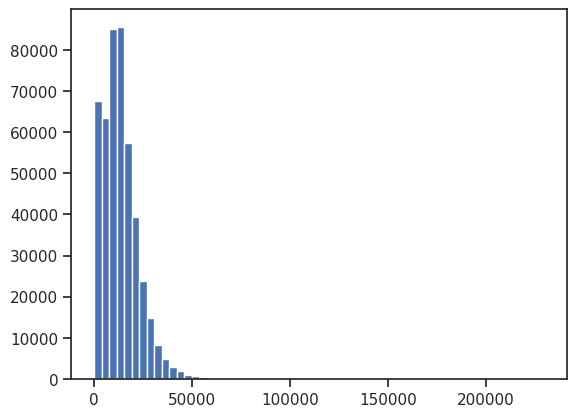

In [ ]:
plt.hist(data['sellingprice'], 60)
plt.show()

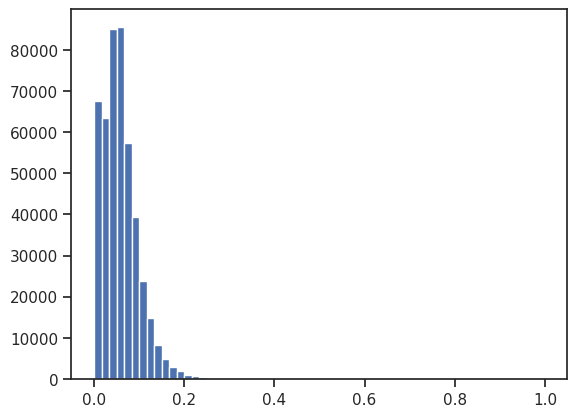

In [ ]:
plt.hist(sc1_data, 60)
plt.show()

## Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0) - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

In [ ]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['sellingprice']])

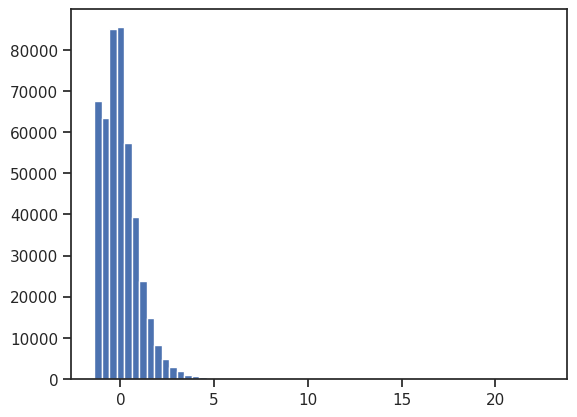

In [ ]:
plt.hist(sc2_data, 60)
plt.show()